In [34]:
import numpy as np
from tiatoolbox.wsicore.wsireader import (
    VirtualWSIReader,
    WSIReader,
    TIFFWSIReader,
    OpenSlideWSIReader,
)
import os
import matplotlib.pyplot as plt
import cv2
from utils import mm2_to_px, dist_to_px, get_tumor_stroma_mask, slide_nms
import skimage
from PIL import Image
import shutil
import json
from tiatoolbox.annotation.storage import Annotation, SQLiteStore
from shapely import Point, Polygon, box
from wholeslidedata import WholeSlideImage
from wholeslidedata.interoperability.openslide.backend import (
    OpenSlideWholeSlideImageBackend,
)
from wholeslidedata.interoperability.asap.backend import (
    AsapWholeSlideImageBackend,
)

In [ ]:
def get_mpp_from_level(wsi_path, level):
    wsi_reader = WholeSlideImage(wsi_path, backend=AsapWholeSlideImageBackend)
    try:
        mpp = wsi_reader.spacings[level]
    except IndexError:
        print(f"Downsampling level {level} does not exist")
        print("Using mpp = 2")
        mpp = 2
    return mpp

In [ ]:
torch_seg_out_path = "output/seg_out"
tf_seg_out_path = "tf_seg_out/tempout"

wsi_dir = "/home/u1910100/Documents/Tiger_Data/wsitils/images"
total = 0

for image in os.listdir(wsi_dir):
    wsi_name = os.path.splitext(image)[0]
    tf_bulk_path = os.path.join(tf_seg_out_path, f"{wsi_name}_bulk.npy")
    if not os.path.exists(tf_bulk_path):
        print(f"{tf_bulk_path} does not exist")
        continue
    fig, axes = plt.subplots(2, 2)
    tf_bulk_mask = np.load(tf_bulk_path)
    wsi_path = os.path.join(wsi_dir, f"{wsi_name}.tif")

    wsi_reader = WSIReader.open(wsi_path)
    thumb = wsi_reader.slide_thumbnail(resolution=0.3125, units="power")

    # stroma_path = os.path.join(seg_out_path, f"{wsi_name}_stroma.npy")
    tumor_path = os.path.join(tf_seg_out_path, f"{wsi_name}_bulk_tumor.npy")
    tumor_mask = np.load(tumor_path)
    stroma_path = os.path.join(tf_seg_out_path, f"{wsi_name}_bulk_stroma.npy")
    stroma_mask = np.load(stroma_path)

    axes[0, 0].imshow(thumb)
    axes[0, 0].title.set_text(wsi_name)
    axes[0, 0].axis("off")
    axes[0, 1].imshow(tf_bulk_mask)
    axes[0, 1].title.set_text("bulk mask")
    axes[0, 1].axis("off")
    axes[1, 0].imshow(stroma_mask)
    axes[1, 0].title.set_text("bulk stroma")
    axes[1, 0].axis("off")
    axes[1, 1].imshow(tumor_mask)
    axes[1, 1].title.set_text("bulk tumor")
    axes[1, 1].axis("off")
    plt.show()
    save_path = os.path.join(eval_dir, f"{wsi_name}.png")
    fig.savefig(
        save_path,
        bbox_inches="tight",
        pad_inches=0,
    )
    fig.clf()
    plt.close()

    total += 1

print(total)

In [ ]:
wsi_dir = "/media/u1910100/Extreme SSD/data/tiger/wsitils/images"
overlay = "/home/u1910100/Documents/Tiger_out_vis/overlays"

In [ ]:
# mask_path = "/media/u1910100/Extreme SSD/data/tiger/wsitils/tissue-masks/106S_tissue.tif"
mask_path = "/media/u1910100/Extreme SSD/data/tiger/wsitils/images/106S.tif"
mask_reader = WSIReader.open(mask_path)
print(mask_reader.info.as_dict())
mask = mask_reader.slide_thumbnail(resolution=5, units="power")
print(mask.shape, mask.dtype)
plt.imshow(mask)
# mask = (mask * 255).astype('uint8')
# heatmap_img = Image.fromarray(mask)
# heatmap_img.save(os.path.join(overlay, f"104S.png"))

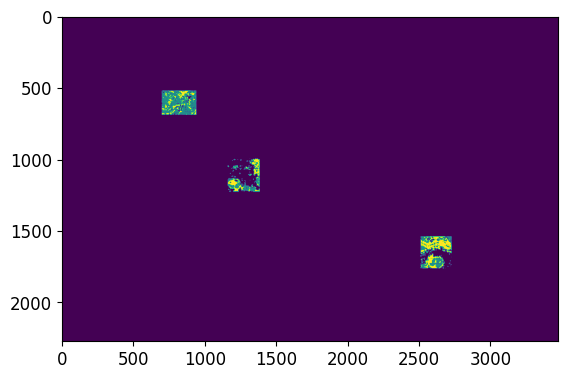

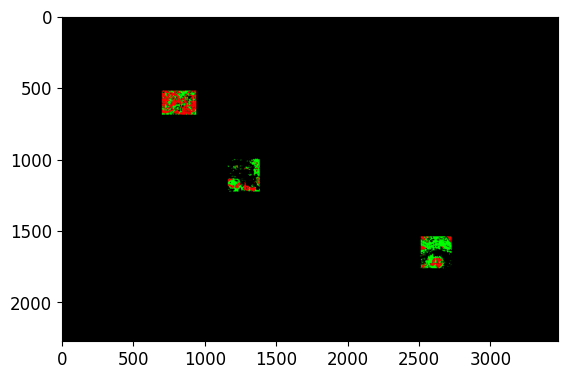

In [35]:
mask_path = "/home/u1910100/Documents/Tiger_Data/output/images/breast-cancer-segmentation-for-tils/segmentation.tif"
mask_reader = WholeSlideImage(mask_path, backend=AsapWholeSlideImageBackend)
mpp = get_mpp_from_level(mask_path, 4)
mask = mask_reader.get_slide(spacing=mpp)[:, :, 0]
# mask_reader = WSIReader.open(mask_path)
# mask = mask_reader.slide_thumbnail(resolution=1.25, units="power")[:, :, 0]
plt.imshow(mask)
plt.show()

heatmap = np.zeros(shape=(mask.shape[0], mask.shape[1], 3), dtype=np.uint8)
heatmap[:, :, 0] = np.where(mask == 1, 255, 0)
heatmap[:, :, 1] = np.where(mask == 2, 255, 0)

plt.imshow(heatmap)
plt.show()

heatmap_img = Image.fromarray(heatmap)
heatmap_img.save(os.path.join(overlay, f"104S_tissue.png"))

In [ ]:
names = [
    "105S",
    "123S",
    "248B",
    "TC_S01_P000052_C0001_B101",
    "TC_S01_P000124_C0001_B101",
]

for name in names:
    tumor_mask = np.load(os.path.join(torch_seg_out_path, f"{name}_tumor.npy"))
    stroma_mask = np.load(os.path.join(torch_seg_out_path, f"{name}_stroma.npy"))
    stroma_bulk = np.load(os.path.join(torch_seg_out_path, f"{name}_stroma_bulk.npy"))

    heatmap = np.zeros(
        shape=(tumor_mask.shape[0], tumor_mask.shape[1], 3), dtype=np.uint8
    )
    heatmap[:, :, 0] = np.where(stroma_bulk == 1, 255, 0)
    heatmap[:, :, 1] = np.where(tumor_mask == 1, 255, 0)
    heatmap[:, :, 2] = np.where(stroma_mask == 1, 255, 0)

    plt.imshow(heatmap)
    plt.show()

    heatmap_img = Image.fromarray(heatmap)
    heatmap_img.save(os.path.join(overlay, f"{name}.png"))

    # shutil.copyfile(f"{wsi_dir}/{name}.tif", os.path.join(overlay, f"{name}.tiff"))

In [32]:
def points_to_annotation_store(points: list):
    """
    Args: points(list): list of (x,y) coordinates
    """
    annotation_store = SQLiteStore()

    for coord in points:
        annotation_store.append(
            Annotation(
                geometry=Polygon.from_bounds(
                    coord[0] - 8, coord[1] - 8, coord[0] + 8, coord[1] + 8
                ),
                properties={"class": 1, "type": "TIL"},
            )
            # Annotation(geometry=Point(coord[0], coord[1]), properties={"class": 1, "type": "TIL"})
        )

    return annotation_store

In [33]:
wsi_without_ext = "104S"
cell_points_dir = "/home/u1910100/Documents/Tiger_Data/tempoutput"
cell_points_path = os.path.join(cell_points_dir, f"{wsi_without_ext}_points.json")

with open(cell_points_path, "r") as fp:
    cell_points = json.load(fp)

# nms_points = slide_nms(slide_path=wsi_path, cell_points=cell_points, tile_size=2048)
print(len(cell_points))
store = points_to_annotation_store(cell_points)
store.dump(os.path.join(overlay, f"{wsi_without_ext}.db"))

2315


In [ ]:
import numpy as np

from matplotlib import pyplot as plt

plt.rc("font", size=12)

path = "/home/u1910100/Documents/Tiger_Data/output/images/breast-cancer-segmentation-for-tils/segmentation.tif"

mask_path = "/media/u1910100/Extreme SSD/data/tiger/wsitils/tissue-masks/TC_S01_P000106_C0001_B101_tissue.tif"

mask_reader = WholeSlideImage(mask_path, backend=AsapWholeSlideImageBackend)

# wsi = WholeSlideImage(path, backend=OpenSlideWholeSlideImageBackend)


# print(f"wsi path: {mask_reader.path}")
# print(f"level count: {mask_reader.level_count}")
print(f"spacings: {mask_reader.spacings}")
print(f"shapes:  {mask_reader.shapes}")
# print(f"downsamplings: {mask_reader.downsamplings}")

mpp = get_mpp_from_level(mask_reader, 2)
print(mpp)

wsi_reader = WSIReader.open(mask_path)
# print(wsi_reader.info.as_dict())
print(wsi_reader.slide_dimensions(resolution=mpp, units="mpp"))


mask_thumb = mask_reader.get_slide(spacing=mpp)
print(mask_thumb.shape, mask_thumb.dtype)

# plt.imshow(mask_thumb)
# plt.show()

In [30]:
mask_path = "/media/u1910100/Extreme SSD/data/tiger/wsitils/images/106S.tif"
wsi_reader = WSIReader.open(mask_path)
from tiatoolbox.tools.patchextraction import get_patch_extractor
from pprint import pprint

patch_extractor = get_patch_extractor(
    input_img=wsi_reader,
    method_name="slidingwindow",
    patch_size=(512, 512),
    stride=(256, 256),
    resolution=2,
    units="mpp",
    input_mask=mask,
    min_mask_ratio=0.3,
)

pprint(patch_extractor.coordinate_list)
# down_coords = [coords // 2 for coords in patch_extractor.coordinate_list]
down_coords = patch_extractor.coordinate_list / 2
down_coords = np.round(down_coords).astype(int)
pprint(down_coords)

|2024-06-05|14:11:53.301| [WARNING] Metadata: Falling back to TIFF resolution tag for microns-per-pixel (MPP).
|2024-06-05|14:11:53.301| [WARNING] Metadata: Objective power inferred from microns-per-pixel (MPP).


array([[2560, 1536, 3072, 2048],
       [2816, 1536, 3328, 2048],
       [2304, 1792, 2816, 2304],
       [2560, 1792, 3072, 2304],
       [2816, 1792, 3328, 2304],
       [3072, 1792, 3584, 2304],
       [2304, 2048, 2816, 2560],
       [2560, 2048, 3072, 2560],
       [2816, 2048, 3328, 2560],
       [4096, 3840, 4608, 4352],
       [8960, 5120, 9472, 5632],
       [9216, 5120, 9728, 5632],
       [8704, 5376, 9216, 5888],
       [8960, 5376, 9472, 5888],
       [9216, 5376, 9728, 5888],
       [8704, 5632, 9216, 6144],
       [8960, 5632, 9472, 6144],
       [8960, 5888, 9472, 6400]])
array([[1280,  768, 1536, 1024],
       [1408,  768, 1664, 1024],
       [1152,  896, 1408, 1152],
       [1280,  896, 1536, 1152],
       [1408,  896, 1664, 1152],
       [1536,  896, 1792, 1152],
       [1152, 1024, 1408, 1280],
       [1280, 1024, 1536, 1280],
       [1408, 1024, 1664, 1280],
       [2048, 1920, 2304, 2176],
       [4480, 2560, 4736, 2816],
       [4608, 2560, 4864, 2816],
       [4